In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Aim
Postprocess the data collected in the REG calibration experience at the Pavia TRIGA

In [2]:
# Experimental data from calibration of REG control rod at TRIGA reactor in Pavia
Data = [
    [0, np.inf],
    [10.14, 11.77470],
    [15.92, 11.05297],
    [21.15, 13.47766],
    [26.50, 14.22371],
    [38.00, 10.40828],
]

In [3]:
# Define the indexes
Index = []
for k in range(0,len(Data)):
    Index.append(f'Point #{k}')

display(Index)

['Point #0', 'Point #1', 'Point #2', 'Point #3', 'Point #4', 'Point #5']

In [4]:
# Building dataframe
calib = pd.DataFrame(
    Data,
    index = Index,
    columns = ["z (cm)", "tm (s)"]
)

calib

,z (cm),tm (s)
Point #0,0.00,inf
Point #1,10.14,11.77470
Point #2,15.92,11.05297
Point #3,21.15,13.47766
Point #4,26.50,14.22371
Point #5,38.00,10.40828


**From measured time $t_m$ to reactor period $T$**
$$ \frac{n(t)}{n_0} = \exp{\left( \frac{t}{T} \right)} $$
$$ \ln \left(\frac{4.5}{3} \right) = \frac{t_m}{T} $$
$$ T \sim 2.47 \cdot t_m $$


In [5]:
# Calculate reactor period associated to each measured time
reacPeriod = 2.47 * calib["tm (s)"].values
calib["T (s)"] = reacPeriod

In [6]:
calib

,z (cm),tm (s),T (s)
Point #0,0.00,inf,inf
Point #1,10.14,11.77470,29.083509
Point #2,15.92,11.05297,27.300836
Point #3,21.15,13.47766,33.289820
Point #4,26.50,14.22371,35.132564
Point #5,38.00,10.40828,25.708452


In [7]:
# Set data of precursors
DataPrecursors= [
    [3.07E-4, 0.0124],
    [8.40E-4, 0.0305],
    [2.88E-3, 0.111],
    [1.43E-3, 0.301],
    [1.60E-3, 1.14],
    [2.41E-4, 3.01],
]

IndexPrecursors = []
for k in range(0,len(DataPrecursors)):
    IndexPrecursors.append(f'Group #{k+1}')

kineticData = pd.DataFrame(
    DataPrecursors,
    index = IndexPrecursors,
    columns = [r"beta_i", "lambda_i (s^-1)"]
)

display(kineticData)

Lambda = 6.00E-5 # (s) mean generation time 
beta = 1e5 * np.sum(kineticData["beta_i"].values) # (pcm)

print(r"Mean generation time: $\Lambda$ = {:.2e}".format(Lambda))
print(r"Delayed neutron fraction $\beta$ = {:.5f}".format(beta))

,beta_i,lambda_i (s^-1)
Group #1,0.000307,0.0124
Group #2,0.000840,0.0305
Group #3,0.002880,0.1110
Group #4,0.001430,0.3010
Group #5,0.001600,1.1400
Group #6,0.000241,3.0100


Mean generation time: $\Lambda$ = 6.00e-05
Delayed neutron fraction $\beta$ = 729.80000


The reactivity associated to the $k$-th experimental point is evaluated as:
$$ \rho_k = \frac{\Lambda}{T_k} + \sum_i \frac{\beta_i}{1 + \lambda_i T_k} $$

In [8]:
# Calculate reactivity and store it
rho = np.zeros(len(Data))

for k in range(len(rho)):
    Tk = calib["T (s)"][k]

    for i in range(len(kineticData)):
        bi = kineticData["beta_i"][i]
        li = kineticData["lambda_i (s^-1)"][i]

        rho[k] +=  bi / (1 +  li * Tk)

    rho[k] += Lambda / Tk

calib["rho (pcm)"] = rho * 1e5     
calib["rho ($)"] = calib["rho (pcm)"].values / beta

In [9]:
calib

,z (cm),tm (s),T (s),rho (pcm),rho ($)
Point #0,0.00,inf,inf,0.000000,0.000000
Point #1,10.14,11.77470,29.083509,155.013389,0.212405
Point #2,15.92,11.05297,27.300836,161.231551,0.220926
Point #3,21.15,13.47766,33.289820,142.252237,0.194919
Point #4,26.50,14.22371,35.132564,137.360990,0.188217
Point #5,38.00,10.40828,25.708452,167.280832,0.229215


In [10]:
# Integral reactivity
rho_int = np.zeros(len(Data))

rho_int[0] = calib["rho ($)"][0]
for k in range(1,len(Data)):
    rho_int[k] = rho_int[k-1] + calib["rho ($)"][k]

calib["rho_int ($)"] = rho_int

In [11]:
calib

,z (cm),tm (s),T (s),rho (pcm),rho ($),rho_int ($)
Point #0,0.00,inf,inf,0.000000,0.000000,0.000000
Point #1,10.14,11.77470,29.083509,155.013389,0.212405,0.212405
Point #2,15.92,11.05297,27.300836,161.231551,0.220926,0.433331
Point #3,21.15,13.47766,33.289820,142.252237,0.194919,0.628250
Point #4,26.50,14.22371,35.132564,137.360990,0.188217,0.816468
Point #5,38.00,10.40828,25.708452,167.280832,0.229215,1.045682


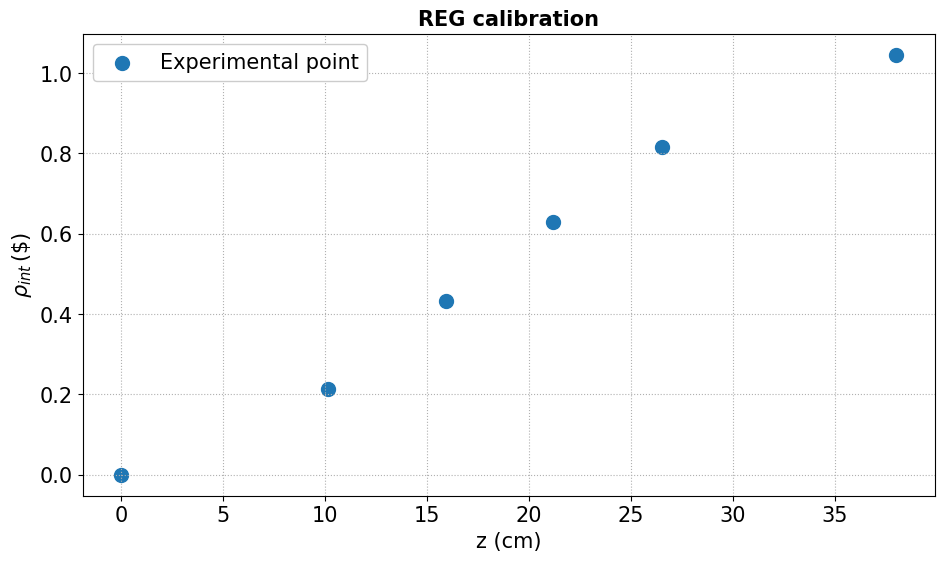

In [12]:
fig, ax = plt.subplots(figsize = (11,6))

lbl_size = 15
tick_size = 15

ax.scatter(calib["z (cm)"], calib["rho_int ($)"], label = "Experimental point", s = 100)
ax.set_title("REG calibration", fontsize = lbl_size, fontweight="bold")
ax.set_xlabel("z (cm)", fontsize = lbl_size)
ax.set_ylabel(r"$\rho_{int} \, (\$)$", fontsize = lbl_size)
ax.tick_params(axis='both', which='both', labelsize=tick_size)
ax.grid(linestyle = ':')
ax.legend(fontsize = lbl_size, framealpha = 1)


**The integral reactivity can be fitted by a sine-shaped curve**
$$ \rho_{int} (z) = A + B \sin(C z + D) $$

Let's find the parameters {A,B,C,D}

In [13]:
def sin_model(z, A, B, C, D):
    return A + B * np.sin(C * z + D)

Aguess = 1
Bguess = 1
Cguess = np.pi / calib["z (cm)"][-1]
Dguess = -np.pi / 2

initial_guess = [Aguess, Bguess, Cguess, Dguess] 

popt, _ = curve_fit(sin_model, calib["z (cm)"], calib["rho_int ($)"], p0=initial_guess)
A, B, C, D = popt
print(f"Fitted parameters: A={A}, B={B}, C={C}, D={D}")

Fitted parameters: A=0.516895009487156, B=0.5321910068887491, C=0.07333001310647268, D=-1.3391778525225178


In [14]:
z_fit = np.linspace(calib["z (cm)"][0], calib["z (cm)"][-1], 400)
rho_fit = sin_model(z_fit, *popt)

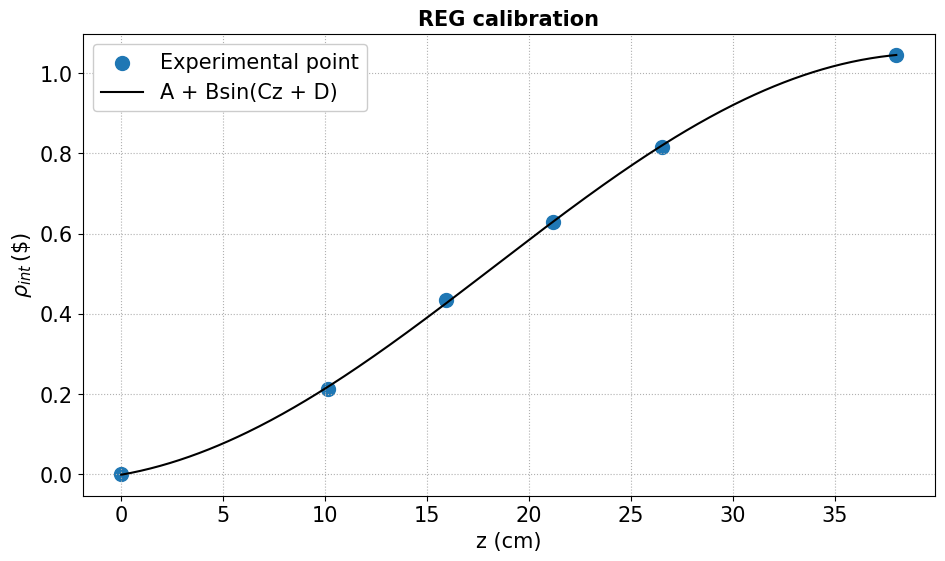

In [15]:
fig, ax = plt.subplots(figsize = (11,6))

lbl_size = 15
tick_size = 15

ax.scatter(calib["z (cm)"], calib["rho_int ($)"], label = "Experimental point", s = 100)
ax.plot(z_fit, rho_fit, color = 'black', label = "A + Bsin(Cz + D)")
ax.set_title("REG calibration", fontsize = lbl_size, fontweight="bold")
ax.set_xlabel("z (cm)", fontsize = lbl_size)
ax.set_ylabel(r"$\rho_{int} \, (\$)$", fontsize = lbl_size)
ax.tick_params(axis='both', which='both', labelsize=tick_size)
ax.grid(linestyle = ':')
ax.legend(fontsize = lbl_size, framealpha = 1)

Calculation of differential reactivity
$$ \rho_{diff} (z) = \frac{d\rho}{dz} = BC  \cos \left( C  z + D \right)$$

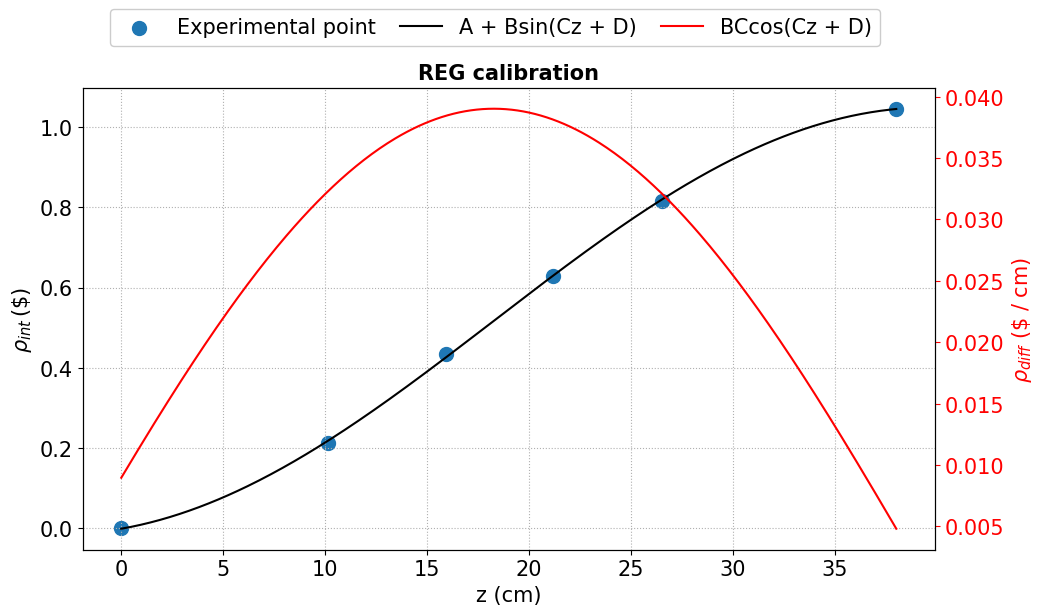

In [16]:
rho_diff = B * C * np.cos(C * z_fit + D)

fig, ax = plt.subplots(figsize = (11,6))

lbl_size = 15
tick_size = 15

ax.scatter(calib["z (cm)"], calib["rho_int ($)"], label = "Experimental point", s = 100)
ax.plot(z_fit, rho_fit, color = 'black', label = "A + Bsin(Cz + D)")
ax.set_title("REG calibration", fontsize = lbl_size, fontweight="bold")
ax.set_xlabel("z (cm)", fontsize = lbl_size)
ax.set_ylabel(r"$\rho_{int} \, (\$)$", fontsize = lbl_size)
ax.tick_params(axis='both', which='both', labelsize=tick_size)
ax.grid(linestyle = ':')

ax2 = ax.twinx()
ax2.plot(z_fit, rho_diff, color = 'red', label = "BCcos(Cz + D)")
ax2.set_ylabel(r"$\rho_{diff}$ (\$ / cm)", color = 'red', fontsize = lbl_size)
ax2.tick_params(axis= 'y', which='both', labelsize=tick_size, colors = 'red')

fig.legend(fontsize = lbl_size, framealpha = 1, bbox_to_anchor=(0.15, 0.95, 0.7, 0.1), loc="lower left", mode="expand", borderaxespad=0, ncol=3)